In [ ]:
# Required packages

import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
import numpy as np

In [ ]:
# Load data from All DynamoDB Tables

TRIP_ARCHIVE_TABLE = "mta-pipeline-trips-table"
ALERTS_TABLE = "mta-pipeline-alerts-table"
VEHICLE_POSITIONS_TABLE = "mta-pipeline-vehicle-table"

dynamodb = boto3.resource('dynamodb')

# Scan a DynamoDB table and retrieve all items
def scan_full_table(table_name):
    print(f"Scanning table: {table_name}...")
    table = dynamodb.Table(table_name)
    response = table.scan()
    items = response.get('Items', [])
    while 'LastEvaluatedKey' in response:
        response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        items.extend(response.get('Items', []))
    print(f"-> Found {len(items)} items.")
    return items

trip_items = scan_full_table(TRIP_ARCHIVE_TABLE)
alert_items = scan_full_table(ALERTS_TABLE)
position_items = scan_full_table(VEHICLE_POSITIONS_TABLE)

print("Data loading complete")

Scanning table: mta-pipeline-trips-table...
-> Found 1077653 items.
Scanning table: mta-pipeline-alerts-table...
-> Found 2983 items.
Scanning table: mta-pipeline-vehicle-table...
-> Found 547929 items.

--- Data loading complete. ---


In [ ]:
# Process Trip Update Data

# Flatten the nested trip update data. Each row will be a single stop prediction.
flattened_trips = []
for item in trip_items:
    for prediction in item.get('stop_predictions', []):
        flattened_trips.append({
            'event_id': item.get('event_id'),
            'ingestion_timestamp': item.get('ingestion_timestamp'),
            'trip_id': item.get('trip_id'),
            'route_id': item.get('route_id'),
            'stop_id': prediction.get('stop_id'),
            'stop_name': prediction.get('stop_name'),
            'predicted_arrival_time': prediction.get('predicted_arrival_time'),
            'scheduled_arrival_time': prediction.get('scheduled_arrival_time'),
            'calculated_delay_seconds': prediction.get('calculated_delay_seconds')
        })

df_trips = pd.DataFrame(flattened_trips)

df_trips['calculated_delay_seconds'] = pd.to_numeric(df_trips['calculated_delay_seconds'], errors='coerce')
df_trips['ingestion_timestamp'] = pd.to_datetime(df_trips['ingestion_timestamp'])

# Make extra features for the plots: delay_minutes, time of day, day of week
df_trips['calculated_delay_minutes'] = df_trips['calculated_delay_seconds'] / 60
df_trips['time_of_day'] = df_trips['ingestion_timestamp'].dt.tz_convert('America/New_York').dt.hour
df_trips['day_of_week'] = df_trips['ingestion_timestamp'].dt.tz_convert('America/New_York').dt.day_name()

# Drop rows where calculated delay is missing (many schedules weren't available in the static data)
df_trips.dropna(subset=['calculated_delay_seconds'], inplace=True)

df_trips = df_trips[
    (df_trips['calculated_delay_minutes'] > -600) &
    (df_trips['calculated_delay_minutes'] < 600)
]

print("Trip Update data transformed. Sample:")
df_trips.head()

Trip Update data transformed. Sample:


,event_id,ingestion_timestamp,trip_id,route_id,stop_id,stop_name,predicted_arrival_time,scheduled_arrival_time,calculated_delay_seconds,calculated_delay_minutes,time_of_day,day_of_week
48,813e693e-ae8b-46c5-a635-88c3780f5279,2025-12-02 09:28:24.997730+00:00,024550_3..N90R,3,301N,Harlem-148 St,1764667818,04:33:00,-162.0,-2.700000,4,Tuesday
68,6ad13ee6-7f0d-4f9f-8b42-344a610e5e43,2025-12-02 03:08:25.169835+00:00,129150_6..S01R,6,623S,110 St,1764644908,22:04:00,268.0,4.466667,22,Monday
69,6ad13ee6-7f0d-4f9f-8b42-344a610e5e43,2025-12-02 03:08:25.169835+00:00,129150_6..S01R,6,624S,103 St,1764644998,22:05:30,268.0,4.466667,22,Monday
70,6ad13ee6-7f0d-4f9f-8b42-344a610e5e43,2025-12-02 03:08:25.169835+00:00,129150_6..S01R,6,625S,96 St,1764645088,22:07:00,268.0,4.466667,22,Monday
71,6ad13ee6-7f0d-4f9f-8b42-344a610e5e43,2025-12-02 03:08:25.169835+00:00,129150_6..S01R,6,626S,86 St,1764645208,22:09:00,268.0,4.466667,22,Monday


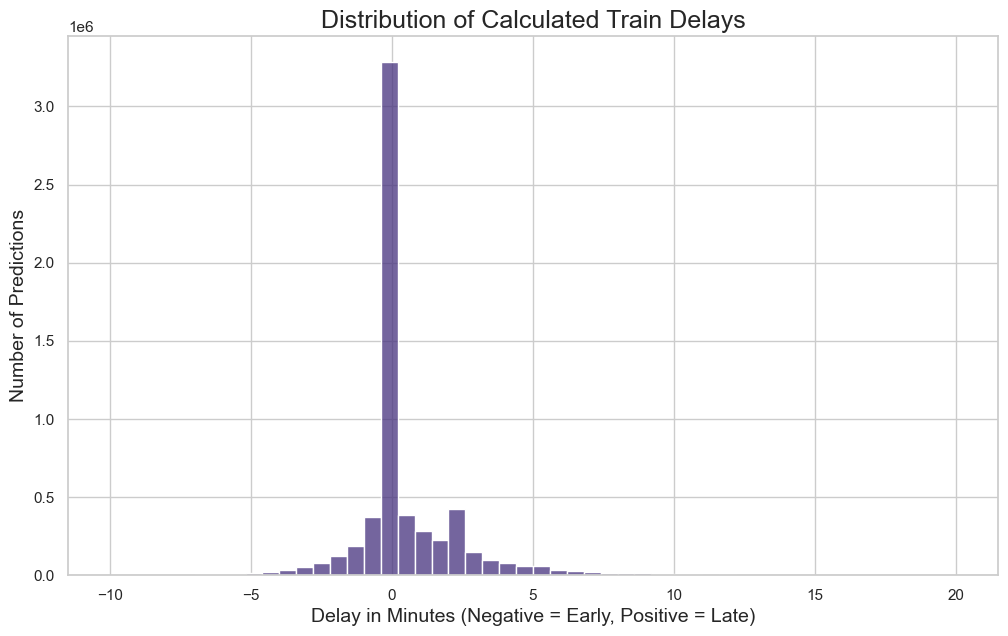

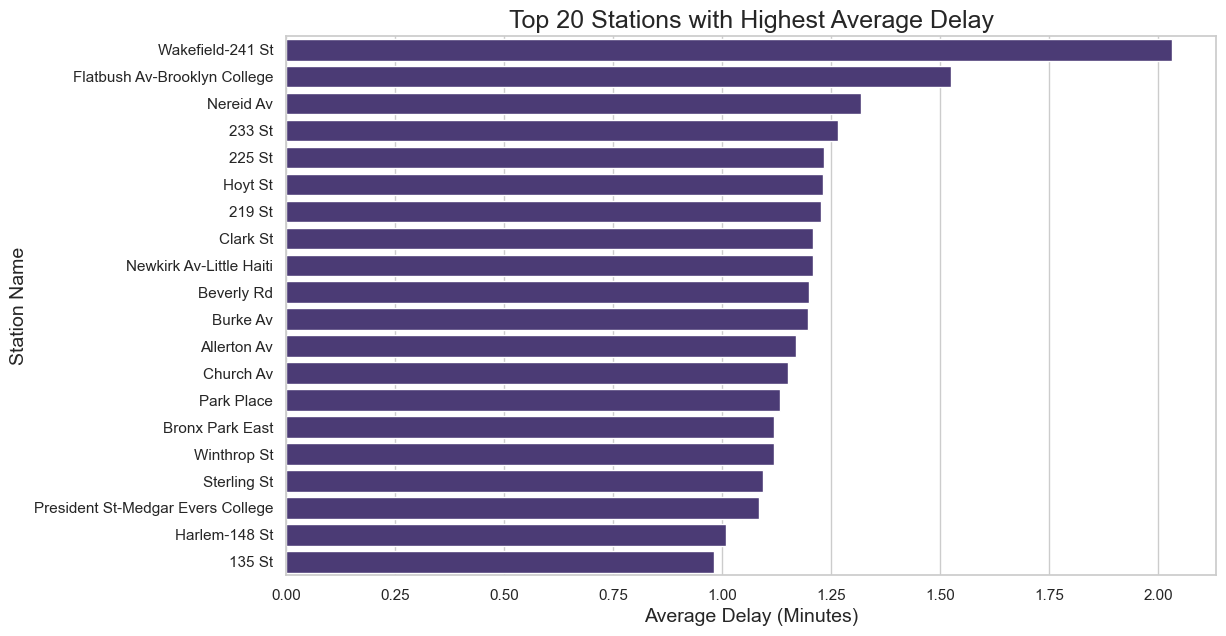

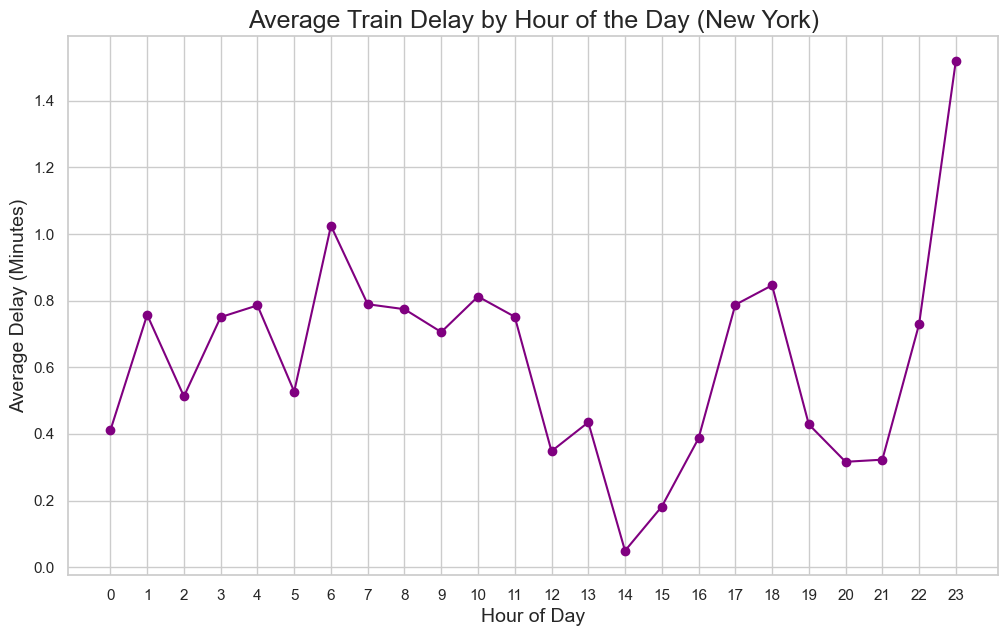

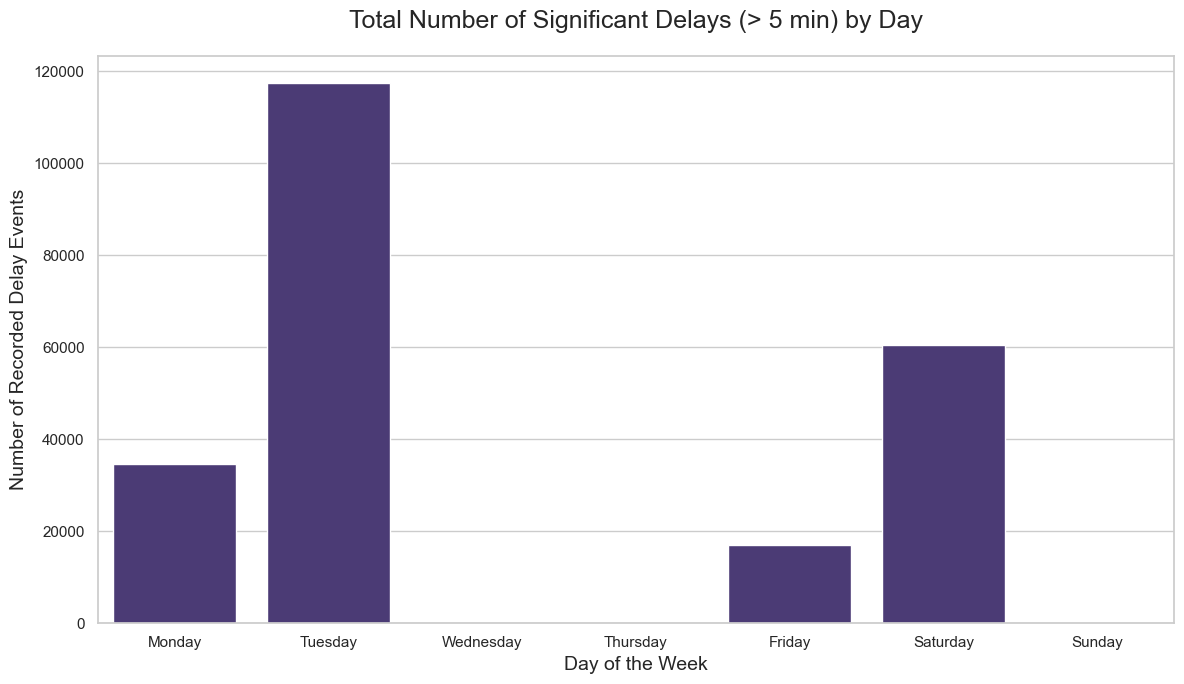

Overall Delay Statistics (in minutes):
count    6.148303e+06
mean     5.543499e-01
std      2.234101e+00
min     -3.500000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      8.333333e-01
max      5.283333e+01
Name: calculated_delay_minutes, dtype: float64


In [ ]:
sns.set_theme(style="whitegrid", palette="viridis")

# Plot 1. Distribution of delays
plt.figure(figsize=(12, 7))
sns.histplot(df_trips['calculated_delay_minutes'], bins=50, binrange=(-10, 20))
plt.title('Distribution of Calculated Train Delays', fontsize=18)
plt.xlabel('Delay in Minutes (Negative = Early, Positive = Late)', fontsize=14)
plt.ylabel('Number of Predictions', fontsize=14)
plt.show()

# Plot 2. Which station experienced the most delays.
station_counts = df_trips['stop_name'].value_counts()
stations_with_enough_data = station_counts[station_counts > 100].index

avg_delay_by_station = df_trips[df_trips['stop_name'].isin(stations_with_enough_data)].groupby('stop_name')['calculated_delay_minutes'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 7))
sns.barplot(x=avg_delay_by_station.values, y=avg_delay_by_station.index)
plt.title('Top 20 Stations with Highest Average Delay', fontsize=18)
plt.xlabel('Average Delay (Minutes)', fontsize=14)
plt.ylabel('Station Name', fontsize=14)
plt.show()

# Plot 3. How does delays vary with the current time of day.
avg_delay_by_hour = df_trips.groupby('time_of_day')['calculated_delay_minutes'].mean()

plt.figure(figsize=(12, 7))
avg_delay_by_hour.plot(kind='line', marker='o', color='purple')
plt.title('Average Train Delay by Hour of the Day (New York)', fontsize=18)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Average Delay (Minutes)', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Plot 4. Amount of delays based on the day of the week. 
# This plot sucks because the data collection failed on Wednesday and Thursday (there was a bug and I didn't have the chance to fix it at that time)

# Need a new DataFrame with significant delays.
DELAY_THRESHOLD_MINUTES = 5 # e.g., 5 minutes
df_significant_delays = df_trips[df_trips['calculated_delay_minutes'] > DELAY_THRESHOLD_MINUTES].copy()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 7))
delay_counts_by_day = df_significant_delays['day_of_week'].value_counts().reindex(day_order, fill_value=0)
sns.barplot(x=delay_counts_by_day.index, y=delay_counts_by_day.values)
plt.title(f'Total Number of Significant Delays (> {DELAY_THRESHOLD_MINUTES} min) by Day', fontsize=18, pad=20)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Recorded Delay Events', fontsize=14)
plt.tight_layout()
plt.show()

print("Overall Delay Statistics (in minutes):")
print(df_trips['calculated_delay_minutes'].describe())

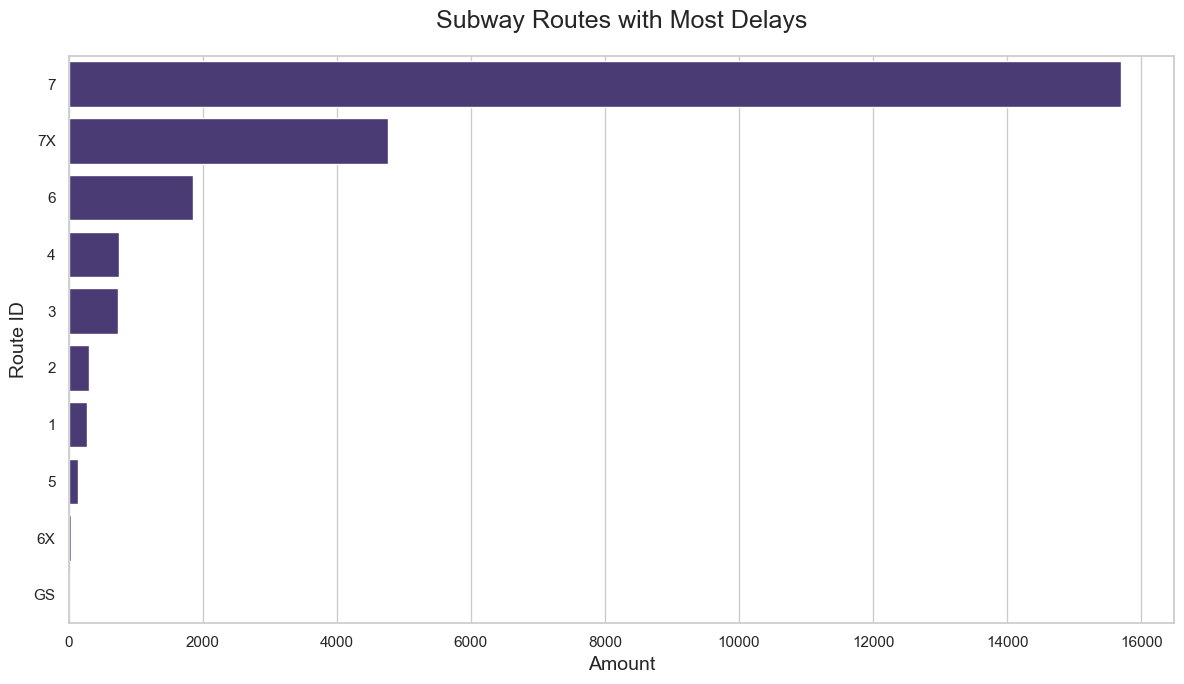

In [33]:
if alert_items:
    
    flat_alerts = []
    for alert in alert_items:
        if 'informedEntity' in alert and alert['informedEntity'] is not None:
            for entity in alert['informedEntity']:
                route_id = None
                if 'routeId' in entity and entity['routeId'] is not None:
                    route_id = entity['routeId']
                elif 'trip' in entity and 'routeId' in entity['trip'] and entity['trip']['routeId'] is not None:
                    route_id = entity['trip']['routeId']
                
                if route_id:
                    flat_alerts.append({
                        'alert_id': alert.get('alert_id'),
                        'header': alert.get('header'),
                        'affected_route_id': route_id
                    })

    if flat_alerts:
        df_alerts = pd.DataFrame(flat_alerts)

        # Plot 4. Which station gets the most delays?
        plt.figure(figsize=(12, 7))
        
        alert_counts_by_route = df_alerts['affected_route_id'].value_counts()
        sns.barplot(x=alert_counts_by_route.values, y=alert_counts_by_route.index)
        plt.title('Subway Routes with Most Delays', fontsize=18, pad=20)
        plt.xlabel('Amount', fontsize=14)
        plt.ylabel('Route ID', fontsize=14)
        plt.tight_layout()
        plt.show()
else:
    print("No alert data found to analyze.")